The dataset used in this notebook was compiled by me in several other notebooks. See the `compile_and_filter_dataset` folder in this repository for the detailed process of how the data was collected. Here is a summary of the work done to collect this data.

#### 1. Get movie discussions
Use the PRAW library, a wrapper for the Reddit API.
* Collect the URLs and titles for all available official movie discussions on Reddit's r/movies. This should be 1,000 rows. 
    * Filter out discussions not related to movies, such as discussions of award ceremonies and end-of-year threads.
    * Use RegEx to clean up movie titles. Strip words from the post's title like
        * "official discussion"
        * "spoilers"
        * "international release"
    *  Save resulting dataframe as `movies_cleaned.csv`.

#### 2. Get comments from movies
Using PRAW and the URLS collected in the last notebook:
* Get the top 100 comments from each discussion thread (some will have fewer than 100) as well as the date the thread was posted.
    * The date will be useful when trying to match the Reddit post with the movie's IMDb score.
    * Save comments and dates in a dictionary format with the discussion's Reddit ID as the key.
    * This dictionary should be read as a dataframe and transposed.
* Save the resulting dictionary as a JSON file `movies_comments.json`.

#### 3. Clean comments
Using the previously saved JSON file:
* Read it in as a dataframe.
* Combine the comments from movies that were discussed on Reddit twice. Some movies had an discussions for international releases and US releases. Choose one post and ID to act as the ID for this movie.
    * This requires some granular work, since some movies simply have the same title, etc.
* Save this dataframe as a CSV, excluding the comments, as `reddit_movies_final.csv`.
* Explode comments. Resulting dataframe should have tens of thousands of rows.
* Drop duplicate comments.
    * More granular work here. Not all duplicates should be dropped. Only ones that appear to be spam or administrative.
* Remove administrative comments from each discussion. They only show up in a few discussions, but they are usually the first comment and contain keywords like "r/movies", "pinned", or "FYI".
* Save the resulting dataframe as `comments_exploded.csv`.

#### 4. Merge movies with IMDb score
* Download IMDb datasets "title.basics.tsv.gz" and "title.ratings.tsv.gz" from https://www.imdb.com/interfaces/
* Read in the datasets as dataframes. Drop non-movies and merge them on the unique identifier.
* Merge this IMDb dataset with the Reddit movies dataset. Use movie title and release date as the features to merge on.
    * Filter out duplicates. A surprising number of blockbuster movies share a release year and title with other, lesser known movies.
        * This requires granular work and care. Some Reddit movies might match with the wrong IMDb movie. Some Reddit movies were discussed in the year after the movie was released.
    * Some movies in the Reddit dataframe need their titles changed to match the IMDb counterpart (misspelled).
* Merge the resulting dataset with the comments dataset.
* Save resulting data as `data_final.csv`.

In [36]:
import numpy as np
import pandas as pd
import warnings
import datetime

from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, r2_score
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import RootMeanSquaredError, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

from transformers import pipelines

import re
from collections import OrderedDict, Counter
import itertools
import string

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import praw

import json

pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 100
seed = 55
np.random.seed(seed)

In [3]:
df = pd.read_csv('./data/data_final.csv')

In [4]:
df.head()

,id,tconst,title,originalTitle,comments,runtimeMinutes,startYear,post_date_utc,post_year,post_month,post_day,genres,numVotes,averageRating
0,vzcwal,tt13406136,the princess,The Princess,Joey King needs a new agent. She’s proven she has talent but she has so many terrible films on h...,94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6
1,vzcwal,tt13406136,the princess,The Princess,"Silly, but entertaining and non stop action",94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6
2,vzcwal,tt13406136,the princess,The Princess,"The yassification of The Raid\n\nActually, this was fun enough and mad respect to Joey King for ...",94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6
3,vzcwal,tt13406136,the princess,The Princess,"Honestly, this was pretty fun. The plot is nothing special yes.\n\nBut Joey King was actually e...",94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6
4,vzcwal,tt13406136,the princess,The Princess,"Man, I loved this movie. Yeah, it was campy, but whatever. The premise worked for me, I liked th...",94.0,2022,1.657851e+09,2022,7,14,"Action,Drama,Fantasy",11474,5.6


In [5]:
###########################

In [6]:
df_imploded  = df.groupby(['id', 'title', 'averageRating'])[['comments']].agg(list).reset_index()

In [7]:
df_imploded['comments'] = df_imploded['comments'].apply(lambda x: ' '.join(x))

In [8]:
df_imploded['comments'] = df_imploded['comments'].apply(lambda x: x.lower())

In [9]:
df_imploded['comments'] = df_imploded['comments'].apply(
    lambda x: re.sub(
        pattern=r'http\S+', repl='HYPERLINK', string=x)
        )

In [10]:
token_pattern = r"[a-zA-Z]+'?[a-zA-Z]+|\b[iIaA]\b"
# Pattern: Any word with at least two characters, including up to one apostrophe
# Also captures the English words "I" and "a".

tokenizer = RegexpTokenizer(token_pattern)

In [11]:
stemmer = SnowballStemmer('english')

In [12]:
sw_spacy = list(nlp.Defaults.stop_words)
sw_nltk = stopwords.words('english')
stopword_list = list(set(sw_spacy + sw_nltk))

In [13]:
stopword_list_stem = [stemmer.stem(sw) for sw in stopword_list]

In [14]:
df_imploded['comments_tok'] = df_imploded['comments'].apply(tokenizer.tokenize)

In [15]:
df_imploded['comments_tok_sw'] = df_imploded['comments_tok'].apply(lambda x: [t for t in x if t not in stopword_list])

In [16]:
df_imploded['comments_stem'] = df_imploded['comments_tok'].apply(lambda x: [stemmer.stem(t) for t in x])

In [17]:
df_imploded['comments_stem_sw'] = df_imploded['comments_stem'].apply(lambda x: [t for t in x if t not in stopword_list_stem])

In [18]:
df_imploded

,id,title,averageRating,comments,comments_tok,comments_tok_sw,comments_stem,comments_stem_sw
0,47szbr,"crouching tiger, hidden dragon: sword of destiny",6.1,"just finished this, and i thought it was ok. compared to the first it seemed a lot more, i don't...","[just, finished, this, and, i, thought, it, was, ok, compared, to, the, first, it, seemed, a, lo...","[finished, thought, ok, compared, lot, know, cheesy, sorta, fun, way, glad, cast, moving, wu, da...","[just, finish, this, and, i, thought, it, was, ok, compar, to, the, first, it, seem, a, lot, mor...","[finish, thought, ok, compar, lot, know, cheesi, sorta, fun, way, glad, cast, wu, dang, mountain..."
1,48vhc8,zootopia,8.0,"""hold on, walter and jesse are at the door.""\n\ni thought that scene felt similar to breaking ba...","[hold, on, walter, and, jesse, are, at, the, door, i, thought, that, scene, felt, similar, to, b...","[hold, walter, jesse, door, thought, scene, felt, similar, breaking, bad, consider, zootopia, sm...","[hold, on, walter, and, jess, are, at, the, door, i, thought, that, scene, felt, similar, to, br...","[hold, walter, jess, door, thought, scene, felt, similar, break, bad, consid, zootopia, smartest..."
2,48vhmk,whiskey tango foxtrot,6.6,"i personally enjoyed it. not the best, not the worst, but i liked it. i liked the way they handl...","[i, personally, enjoyed, it, not, the, best, not, the, worst, but, i, liked, it, i, liked, the, ...","[personally, enjoyed, best, worst, liked, liked, way, handled, humor, especially, genre, martin,...","[i, person, enjoy, it, not, the, best, not, the, worst, but, i, like, it, i, like, the, way, the...","[person, enjoy, best, worst, like, like, way, handl, humor, especi, genr, martin, freeman, scruf..."
3,48vhsf,london has fallen,5.9,"if you go into this movie expecting good action, gerard butler being a badass, and a terrible pl...","[if, you, go, into, this, movie, expecting, good, action, gerard, butler, being, a, badass, and,...","[movie, expecting, good, action, gerard, butler, badass, terrible, plot, bases, covered, kind, m...","[if, you, go, into, this, movi, expect, good, action, gerard, butler, be, a, badass, and, a, ter...","[movi, expect, good, action, gerard, butler, badass, terribl, plot, base, cover, kind, movi, com..."
4,49wvnj,10 cloverfield lane,7.2,"i kept going back and forth: ""is he crazy? no, he's right. no he's crazy. holy shit he's both...","[i, kept, going, back, and, forth, is, he, crazy, no, he's, right, no, he's, crazy, holy, shit, ...","[kept, going, forth, crazy, he's, right, he's, crazy, holy, shit, he's, crazy, right, edge, seat...","[i, kept, go, back, and, forth, is, he, crazi, no, he, right, no, he, crazi, holi, shit, he, bot...","[kept, forth, crazi, right, crazi, holi, shit, crazi, right, edg, seat, movi, essenti, hour, lon..."
...,...,...,...,...,...,...,...,...
917,vzcv66,where the crawdads sing,7.1,i did enjoy her house representing the 2 different ways the men treated her . tate was invited o...,"[i, did, enjoy, her, house, representing, the, different, ways, the, men, treated, her, tate, wa...","[enjoy, house, representing, different, ways, men, treated, tate, invited, enter, invited, obser...","[i, did, enjoy, her, hous, repres, the, differ, way, the, men, treat, her, tate, was, invit, ove...","[enjoy, hous, repres, differ, way, men, treat, tate, invit, enter, invit, observ, respect, chase..."
918,vzcvkz,mrs harris goes to paris,7.1,this was so cute it just made me smile the whole time. highly recommend. the only word for this...,"[this, was, so, cute, it, just, made, me, smile, the, whole, time, highly, recommend, the, only,...","[cute, smile, time, highly, recommend, word, movie, sweet, lovely, tiny, french, pastry, film, w...","[this, was, so, cute, it, just, made, me, smile, the, whole, time, high, recommend, the, onli, w...","[cute, smile, time, high, recommend, word, movi, sweet, love, tini, french, pastri, film, want, ..."
919,vzcvsd,the sea beast,7.1,absolutely cr

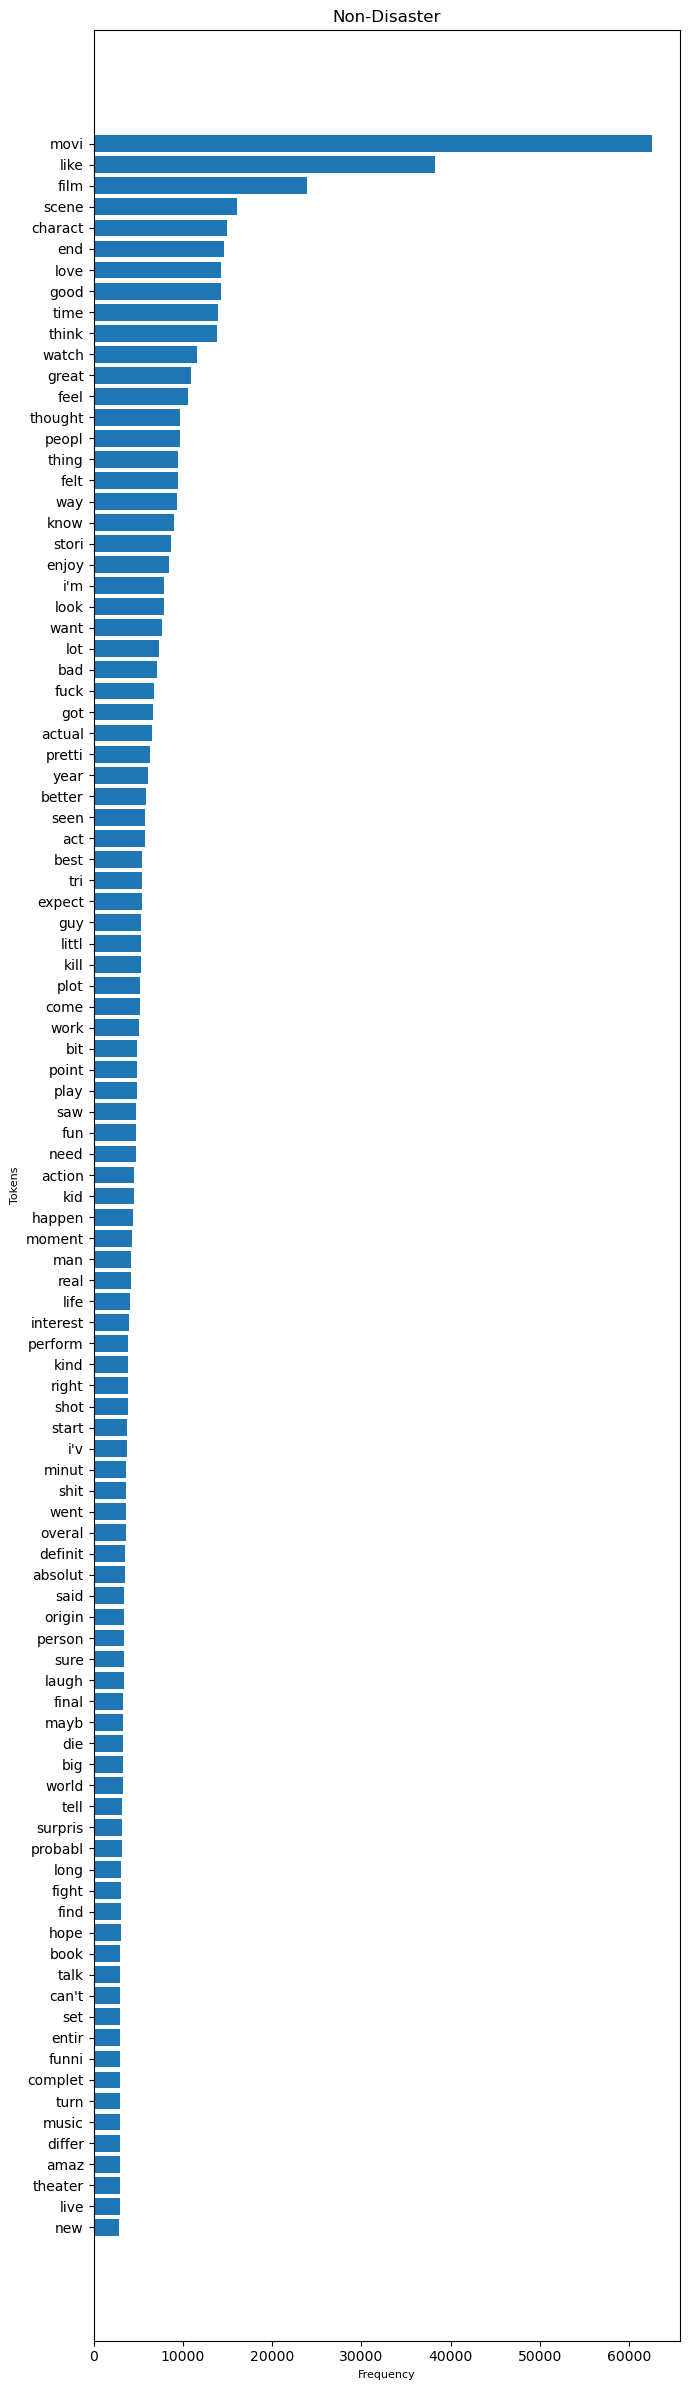

In [19]:
fig, axes = plt.subplots(figsize=(7, 24))
fd_0 = FreqDist(df_imploded['comments_stem_sw'].explode()).most_common(100)
fd_0 = OrderedDict(fd_0)
tokens_0 = list(fd_0.keys())[::-1]
freq_0 = list(fd_0.values())[::-1]
# fd_1 = FreqDist(series[y==1].explode()).most_common(cutoff)
# fd_1 = OrderedDict(fd_1)
# tokens_1 = list(fd_1.keys())[::-1]
# freq_1 = list(fd_1.values())[::-1]
# shared_tokens = [t for t in tokens_0 if t in tokens_1]
axes.barh(y=tokens_0, width=freq_0)
# axes[1].barh(y=tokens_1, width=freq_1, color=['C6' if token in shared_tokens else 'C0' for token in tokens_1])
axes.set_ylabel('Tokens', size=8)
axes.set_xlabel('Frequency', size=8)
# axes[1].set_xlabel('Frequency', size=10)
# fig.suptitle(f'Top {cutoff} {token_type}', size=15)
axes.set_title('Non-Disaster')
# axes[1].set_title('Disaster')
# custom_bars = [Line2D([0], [0], color='C6', lw=10), Line2D([0], [0], color='C0', lw=10)]
# axes.legend(custom_bars, ['In common', 'Not in common'])
# axes[1].legend(custom_bars, ['In common', 'Not in common'])
fig.set_facecolor('white');
plt.tight_layout()
plt.show()

In [20]:
comments = df_imploded.drop(columns='averageRating')
target = df_imploded['averageRating']

In [21]:
# Splitting the full dataset into training and testing data

X_train, X_test, y_train, y_test = train_test_split(
    comments, target, test_size=0.2, random_state=seed
)

# Splitting off a validation set

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=.5, random_state=seed
)

In [22]:
df_imploded['comments_stem'].apply(lambda x: ' '.join(x))

0      just finish this and i thought it was ok compar to the first it seem a lot more i don't know che...
1      hold on walter and jess are at the door i thought that scene felt similar to break bad do i cons...
2      i person enjoy it not the best not the worst but i like it i like the way they handl the humor e...
3      if you go into this movi expect good action gerard butler be a badass and a terribl plot you'll ...
4      i kept go back and forth is he crazi no he right no he crazi holi shit he both crazi and right h...
                                                      ...                                                 
917    i did enjoy her hous repres the differ way the men treat her tate was invit over and didn enter ...
918    this was so cute it just made me smile the whole time high recommend the onli word for this movi...
919    absolut crazi that netflix drop this and also the mitchel vs the machin with almost no fanfar bo...
920    offenc to woodi but i feel lik

In [23]:
df_imploded['comments'].sample().apply(lambda x: [stemmer.stem(t) for t in tokenizer.tokenize(x)])

920    [offenc, to, woodi, but, i, feel, like, the, origin, cast, of, jason, statham, would, have, at, ...
Name: comments, dtype: object

In [24]:
tfidf = TfidfVectorizer(
    tokenizer=lambda x: [stemmer.stem(t) for t in tokenizer.tokenize(x)], 
    stop_words=stopword_list_stem,
    max_features=1000
    )

X_train_vec = tfidf.fit_transform(X_train['comments'])

X_train_vec_df = pd.DataFrame(
    X_train_vec.toarray(),
    columns=tfidf.get_feature_names_out(),
    index=X_train.index
    )
X_train_vec_df.head()


c:\Users\zshoo\anaconda3\envs\capstone-env\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['anywh', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'somewh'] not in stop_words.
  warnings.warn(


,abl,absolut,absurd,abus,accent,accept,act,action,actor,actress,...,wrong,wrote,wtf,yeah,year,yes,young,younger,zero,zombi
73,0.005206,0.010689,0.0,0.0,0.005257,0.0,0.008809,0.018561,0.001441,0.002222,...,0.003288,0.000000,0.000000,0.001860,0.008809,0.003801,0.0,0.002714,0.0,0.003924
33,0.000000,0.019685,0.0,0.0,0.000000,0.0,0.037080,0.058005,0.014156,0.000000,...,0.008072,0.000000,0.000000,0.018267,0.030900,0.000000,0.0,0.013329,0.0,0.000000
570,0.068809,0.010597,0.0,0.0,0.020846,0.0,0.029941,0.013382,0.034292,0.000000,...,0.013037,0.060757,0.000000,0.029501,0.059883,0.015073,0.0,0.000000,0.0,0.000000
30,0.020525,0.005268,0.0,0.0,0.000000,0.0,0.029770,0.006653,0.022731,0.017525,...,0.006481,0.000000,0.009585,0.000000,0.014885,0.052456,0.0,0.000000,0.0,0.000000
873,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.057120,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.084419,0.000000,0.000000,0.0,0.000000,0.0,0.000000


In [25]:
scaler = StandardScaler()
X_train_vec_df_scaled = scaler.fit_transform(X_train_vec_df)
X_train_vec_df_scaled = pd.DataFrame(X_train_vec_df_scaled, index=X_train.index, columns=X_train_vec_df.columns)

X_train_vec_df_scaled.head()

,abl,absolut,absurd,abus,accent,accept,act,action,actor,actress,...,wrong,wrote,wtf,yeah,year,yes,young,younger,zero,zombi
73,-0.423015,-0.660692,-0.428631,-0.267666,-0.167235,-0.533879,-1.043812,-0.289625,-0.897807,-0.403272,...,-0.627122,-0.486902,-0.419249,-0.623546,-1.021158,-0.426983,-0.532807,-0.198372,-0.533747,-0.069093
33,-0.850677,-0.208407,-0.428631,-0.267666,-0.379157,-0.533879,0.011531,0.361083,-0.346372,-0.526024,...,-0.266370,-0.486902,-0.419249,0.804222,-0.297361,-0.744104,-0.532807,0.752925,-0.533747,-0.136850
570,4.802222,-0.665334,-0.428631,-0.267666,0.461211,-0.533879,-0.254943,-0.375059,0.526936,-0.526024,...,0.107914,4.773999,-0.419249,1.781792,0.652256,0.513424,-0.532807,-0.441617,-0.533747,-0.136850
30,0.835512,-0.933248,-0.428631,-0.267666,-0.379157,-0.533879,-0.261323,-0.486073,0.025526,0.441946,...,-0.386343,-0.486902,0.217283,-0.785393,-0.822072,3.632120,-0.532807,-0.441617,-0.533747,-0.136850
873,-0.850677,-1.198121,-0.428631,-0.267666,-0.379157,-0.533879,0.759643,-0.595828,-0.960316,-0.526024,...,-0.874989,-0.486902,-0.419249,6.560881,-1.309782,-0.744104,-0.532807,-0.441617,-0.533747,-0.136850


In [26]:
X_test_vec = tfidf.transform(X_test['comments'])

X_test_vec_df = pd.DataFrame(
    X_test_vec.toarray(),
    columns=tfidf.get_feature_names_out(),
    index=X_test.index
    )

X_test_vec_df_scaled = scaler.transform(X_test_vec_df)
X_test_vec_df_scaled = pd.DataFrame(X_test_vec_df_scaled, index=X_test.index, columns=X_test_vec_df.columns)

In [27]:
X_val_vec = tfidf.transform(X_val['comments'])

X_val_vec_df = pd.DataFrame(
    X_val_vec.toarray(),
    columns=tfidf.get_feature_names_out(),
    index=X_val.index
    )

X_val_vec_df_scaled = scaler.transform(X_val_vec_df)
X_val_vec_df_scaled = pd.DataFrame(X_val_vec_df_scaled, index=X_val.index, columns=X_val_vec_df.columns)

In [29]:
n_input = X_train_vec_df_scaled.shape[1]
n_input

1000

In [176]:
set_seed(seed)

model_baseline = models.Sequential()

model_baseline.add(layers.Dropout(0.2, input_shape=(n_input,)))

model_baseline.add(layer=layers.Dense(
    units=500,
    activation='relu',
    input_shape=(n_input,),
    kernel_regularizer=regularizers.L2(.25)
    ))

model_baseline.add(layers.Dropout(0.2))

model_baseline.add(layer=layers.Dense(
    units=400,
    activation='relu',
    kernel_regularizer=regularizers.L2(.25)
    ))

model_baseline.add(layers.Dropout(0.2))

model_baseline.add(layer=layers.Dense(
    units=300,
    activation='relu',
    kernel_regularizer=regularizers.L2(.25)
    ))

# model_baseline.add(layers.Dropout(0.2))

# model_baseline.add(layer=layers.Dense(
#     units=250,
#     activation='relu',
#     kernel_regularizer=regularizers.L2(.25)
#     ))

model_baseline.add(layer=layers.Dense(
    units=1,
    ))

model_baseline.compile(
    optimizer='sgd',
    loss='mse',
    metrics=[RootMeanSquaredError()]
    )

early_stopping = [
    EarlyStopping(monitor='val_loss', patience=10)
    ]

model_hist_baseline = model_baseline.fit(
    np.array(X_train_vec_df_scaled),
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_vec_df_scaled, y_val),
    verbose=True,
    callbacks=early_stopping
)

Epoch 1/100
24/24 [==============================] - 1s 24ms/step - loss: 373.2215 - root_mean_squared_error: 5.6350 - val_loss: 303.8535 - val_root_mean_squared_error: 1.6190
Epoch 2/100
24/24 [==============================] - 0s 10ms/step - loss: 274.3086 - root_mean_squared_error: 1.9892 - val_loss: 256.8706 - val_root_mean_squared_error: 4.3935
Epoch 3/100
24/24 [==============================] - 0s 10ms/step - loss: 222.4732 - root_mean_squared_error: 3.0680 - val_loss: 189.0312 - val_root_mean_squared_error: 1.4539
Epoch 4/100
24/24 [==============================] - 0s 11ms/step - loss: 169.1815 - root_mean_squared_error: 1.2180 - val_loss: 147.7942 - val_root_mean_squared_error: 0.8952
Epoch 5/100
24/24 [==============================] - 0s 10ms/step - loss: 132.8113 - root_mean_squared_error: 0.9281 - val_loss: 116.4358 - val_root_mean_squared_error: 0.8397
Epoch 6/100
24/24 [==============================] - 0s 10ms/step - loss: 104.6383 - root_mean_squared_error: 0.8833 - v

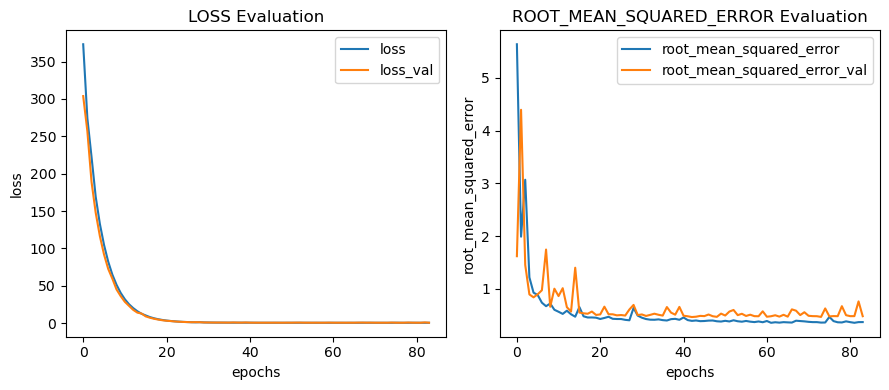

In [177]:
def plot_nn_curves(model_history):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
    fl_ax = axes.flatten()
    for idx, metric in enumerate(['loss', 'root_mean_squared_error']):
        pair = [m for m in model_history.history.keys() if metric in m]
        fl_ax[idx].plot(model_history.history[pair[0]], label=metric)
        fl_ax[idx].plot(model_history.history[pair[1]], label=metric+'_val')
        fl_ax[idx].set_xlabel('epochs')
        fl_ax[idx].set_ylabel(metric)
        fl_ax[idx].set_title(f'{metric.upper()} Evaluation')
        fl_ax[idx].legend()
        plt.tight_layout();

plot_nn_curves(model_hist_baseline)


In [179]:
r2_score(y_val, model_baseline.predict(X_val_vec_df_scaled))

3/3 [==============================] - 0s 3ms/step


0.6950221284263263

In [ ]:
#########################################

In [ ]:
def spacy_lemmatize(text):
    """
    Uses NLTK and SpaCy to tokenize a string and return the lemma of each token.
    """
    sents = [s.text for s in nlp(text).sents]
    sents_tokenized = [tokenizer.tokenize(sent) for sent in sents]
    docs = [nlp(' '.join(tokens)) for tokens in sents_tokenized]
    docs_lemmatized = [[t.lemma_.lower() for t in doc] for doc in docs]
    return list(itertools.chain.from_iterable(docs_lemmatized))

In [ ]:
df['comments_lem'] = df['comments'].apply(spacy_lemmatize)

In [ ]:
df['comments_lem']

In [ ]:
comments_lem_imploded = df.groupby('id').agg(
    {'comments_lem': lambda x: list(itertools.chain.from_iterable(x))}
    ).reset_index()

In [ ]:
comments_imploded

In [ ]:
just_movies = df.drop(columns=['comments', 'comments_lem']).drop_duplicates(subset='id')

In [ ]:
df2 = pd.merge(
    left=just_movies,
    right=comments_lem_imploded,
    how='inner',
    on='id'
)

In [ ]:
df2

In [ ]:
df2['comments_lem_no_sw'] = df2['comments_lem'].apply(lambda x: [t for t in x if t not in stopword_list])

In [ ]:
df2

In [ ]:
################################

In [ ]:
token_pattern = r"[a-zA-Z]+'?[a-zA-Z]+|\b[iIaA]\b"
# Pattern: Any word with at least two characters, including up to one apostrophe
# Also captures the English words "I" and "a".

tokenizer = RegexpTokenizer(token_pattern)

In [ ]:
sw_spacy = list(nlp.Defaults.stop_words)
sw_nltk = stopwords.words('english')
stopword_list = list(set(sw_spacy + sw_nltk))
stopword_list.extend(["i'm"])

In [ ]:
def spacy_lemmatize(text):
    """
    Uses NLTK and SpaCy to tokenize a string and return the lemma of each token.
    """
    sents = [s.text for s in nlp(text).sents]
    sents_tokenized = [tokenizer.tokenize(sent) for sent in sents]
    docs = [nlp(' '.join(tokens)) for tokens in sents_tokenized]
    docs_lemmatized = [[t.lemma_.lower() for t in doc] for doc in docs]
    return list(itertools.chain.from_iterable(docs_lemmatized))

In [ ]:
################################

In [ ]:
example = df['comments'].loc[70690]

In [ ]:
example

In [ ]:
token_pattern = r"[a-zA-Z]+'?[a-zA-Z]+|\b[iIaA]\b"
# Pattern: Any word with at least two characters, including up to one apostrophe
# Also captures the English words "I" and "a".

tokenizer = RegexpTokenizer(token_pattern)

In [ ]:
sw_spacy = list(nlp.Defaults.stop_words)
sw_nltk = stopwords.words('english')
stopword_list = list(set(sw_spacy + sw_nltk))
stopword_list.extend(["i'm"])

In [ ]:
def spacy_lemmatize(text):
    """
    Uses NLTK and SpaCy to tokenize a string and return the lemma of each token.
    """
    sents = [s.text for s in nlp(text).sents]
    sents_tokenized = [tokenizer.tokenize(sent) for sent in sents]
    docs = [nlp(' '.join(tokens)) for tokens in sents_tokenized]
    docs_lemmatized = [[t.lemma_.lower() for t in doc] for doc in docs]
    return list(itertools.chain.from_iterable(docs_lemmatized))

In [ ]:
idx = np.random.choice(df.index)

display(df.loc[[idx]])

print(spacy_lemmatize(df.loc[idx]['comments']))